# Evaluating Bookmakers Efficiency

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sys, os
from scipy.stats import poisson,skellam
from scipy.optimize import minimize

sys.path.insert(0, '/home/igormago/projects/DeepFootball')

from conf.configparser import conf
datasets_path = conf['path']['datasets']

plt.style.use('ggplot')

from core.database import Database
session = Database.get_session_betexplorer()

from sklearn.metrics import brier_score_loss

localhost


In [2]:
bks = session.get_collection('matches').distinct('odds.l.bts.bk.nm')
print('Number of bookmakers with BTTS odds:', len(bks))
print('Bookmakers: ', bks)

dfbks = pd.DataFrame()
dfbks['name'] = bks

Number of bookmakers with BTTS odds: 19
Bookmakers:  ['10Bet', '188BET', '1xBet', '888sport', 'BetVictor', 'Betfair', 'Betfair Exchange', 'Betsafe', 'Betsson', 'Betway', 'ComeOn', 'Interwetten', 'Paddy Power', 'Unibet', 'William Hill', 'bet-at-home', 'bet365', 'bwin', 'youwin']


In [14]:
for i, b in enumerate(bks):
    n_matches = session.get_collection('matches').count_documents({
        'ss.yi':{'$gte': 2017,'$lte': 2018}, 'odds.l.bts':{'$exists':1},'odds.l.bts.bk.nm': b})
    dfbks.loc[i,'n_matches'] = n_matches

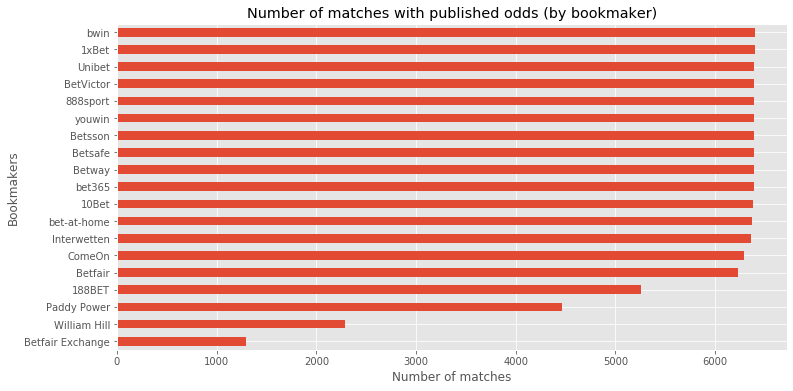

,name,n_matches,margins,scores
6,Betfair Exchange,1293.0,3.576673,0.220927
14,William Hill,2290.0,7.376284,0.212808
12,Paddy Power,4463.0,7.803468,0.209134
1,188BET,5258.0,5.771886,0.219459
5,Betfair,6226.0,6.556246,0.216025
10,ComeOn,6285.0,7.566347,0.208449
11,Interwetten,6364.0,9.386548,0.203202
15,bet-at-home,6371.0,8.163265,0.204594
0,10Bet,6380.0,7.566347,0.208299
16,bet365,6385.0,7.553570,0.210067


In [15]:
dfbks = dfbks.sort_values('n_matches')
ax = dfbks.plot.barh(x='name', y='n_matches', legend=False, figsize=(12,6))
ax.set_xlabel("Number of matches")
ax.set_ylabel("Bookmakers")
ax.set_title("Number of matches with published odds (by bookmaker)")
plt.show()
display(dfbks)

In [17]:
margins = list()
scores = list()

for b in dfbks['name']:
    
    matches = list(session.matches.find ({'odds.l.bts.bk.nm': b, 'ss.yi':{'$gte': 2017,'$lte': 2018}},
                                         {"odds.l.bts.bk.$" : 1, 'res.bts':1}))
    
    if len(matches) > 0:
        odds = pd.DataFrame()
        yes = list()
        no = list() 
        res_yes = list()
        res_no = list()
        
        pred = list()
        
        for m in matches:
            yes.append(m['odds']['l']['bts'][0]['y'])
            no.append(m['odds']['l']['bts'][0]['n'])
            if (m['res']['bts'] == 'y'):
                pred.append(1/m['odds']['l']['bts'][0]['y'])
            else:
                pred.append(1/m['odds']['l']['bts'][0]['n'])

        odds['yes'] = yes
        odds['no'] = no

        odds['yesi'] = 1/odds['yes']
        odds['noi'] = 1/odds['no']
        odds['margin'] = odds['yesi'] + odds['noi']
        
        margin_avg = odds['margin'].median()
        margin_avg = (margin_avg-1)*100
        margins.append(margin_avg)

        odds['yesb'] = odds['yesi']/(odds['yesi'] + odds['noi'])
        odds['nob'] = odds['noi']/(odds['yesi'] + odds['noi'])
        
        target = len(pred)*[1]
        
        bs = brier_score_loss(target, pred)
        scores.append(bs)
        
    else:
        margins.append(0)
        scores.append(0)
    
    
dfbks['margins'] = margins
dfbks['scores'] = scores

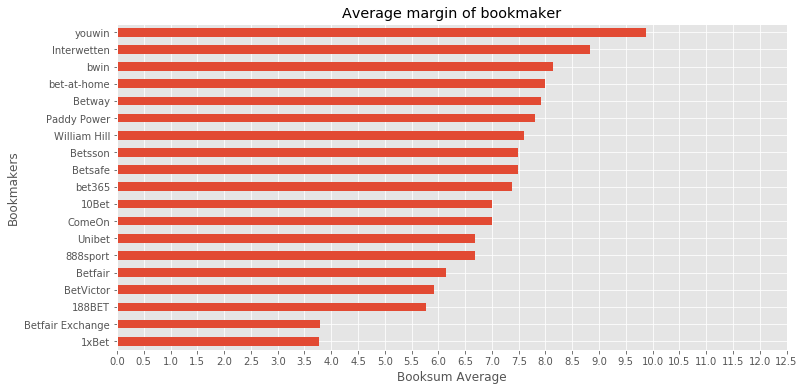

In [18]:
dfbks = dfbks.sort_values('margins')
ax = dfbks.plot.barh(x='name', y='margins', legend=False, figsize=(12,6))
ax.set_xticks(np.arange(0,13,0.5))
ax.set_xlabel("Booksum Average")
ax.set_ylabel("Bookmakers")
ax.set_title("Average margin of bookmaker")
plt.show()

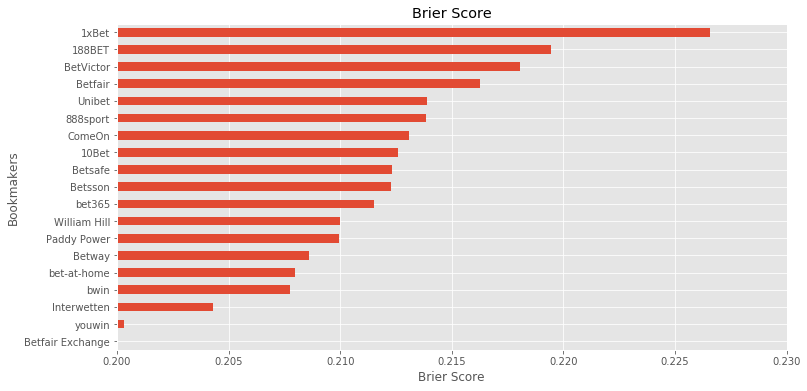

In [20]:
dfbks = dfbks.sort_values('scores')
ax = dfbks.plot.barh(x='name', y='scores', legend=False, figsize=(12,6), xlim=(0.20,0.23))
#ax.set_xticks(np.arange(0.26,0.27,0.001))
ax.set_xlabel("Brier Score")
ax.set_ylabel("Bookmakers")
ax.set_title("Brier Score")
plt.show()